In [1]:
import os, sys

os.environ['KMP_DUPLICATE_LIB_OK']='True' # uncomment this line if omp error occurs on OSX for python 3
os.environ["OMP_NUM_THREADS"] = "4" # export OMP_NUM_THREADS=4
os.environ["OPENBLAS_NUM_THREADS"] = "4" # export OPENBLAS_NUM_THREADS=4 
os.environ["MKL_NUM_THREADS"] = "6" # export MKL_NUM_THREADS=6
os.environ["VECLIB_MAXIMUM_THREADS"] = "4" # export VECLIB_MAXIMUM_THREADS=4
os.environ["NUMEXPR_NUM_THREADS"] = "6" # export NUMEXPR_NUM_THREADS=6

from scipy import linalg
import stomp_functions as stf
from quspin.operators import hamiltonian, commutator
from quspin.basis import spinful_fermion_basis_general
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from qiskit.quantum_info import random_clifford
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

1.26.4


In [2]:
class TOLcmaps(object):
    """
    Class TOLcmaps definition.  Used for generating colormaps for plotting
    """
    def __init__(self):
        """
        """
        self.cmap = None
        self.cname = None
        self.namelist = (
            'rainbow_PuRd',)

        self.funcdict = dict(
            zip(self.namelist,
                (self.__rainbow_PuRd,
                )
               )
        )
        
    def __rainbow_PuRd(self):
        """
        Define colormap 'rainbow_PuRd'.
        """
        clrs = ['#6F4C9B', '#6059A9', '#5568B8', '#4E79C5', '#4D8AC6',
                '#4E96BC', '#549EB3', '#59A5A9', '#60AB9E', '#69B190',
                '#77B77D', '#8CBC68', '#A6BE54', '#BEBC48', '#D1B541',
                '#DDAA3C', '#E49C39', '#E78C35', '#E67932', '#E4632D',
                '#DF4828', '#DA2222']
        self.cmap = LinearSegmentedColormap.from_list(self.cname, clrs)
        self.cmap.set_bad('#FFFFFF')
        
    def get(self, cname='rainbow_PuRd', lut=None):
        """
        Return requested colormap, default is 'rainbow_PuRd'.
        """
        self.cname = cname
        if cname == 'rainbow_discrete':
            self.__rainbow_discrete(lut)
        else:
            self.funcdict[cname]()
        return self.cmap

In [3]:
def tol_cmap(colormap=None, lut=None):
    """
    Continuous and discrete color sets for ordered data.
    
    Return a matplotlib colormap.
    Parameter lut is ignored for all colormaps except 'rainbow_discrete'.
    """
    obj = TOLcmaps()
    if colormap is None:
        return obj.namelist
    if colormap not in obj.namelist:
        colormap = 'rainbow_PuRd'
        print('*** Warning: requested colormap not defined,',
              'known colormaps are {}.'.format(obj.namelist),
              'Using {}.'.format(colormap))
    return obj.get(colormap, lut)

In [4]:
# Set font size of plot elements
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [5]:
# Set up time evolution params
τ = 5
num_steps = 1500
τs, dτ = np.linspace(0, τ, num_steps, retstep=True)

In [6]:
# Define files for saving ovlp data
main_path = "2D_FH_clifford_testing/"
tr_ρs = {}
tr_ρHs = {}
exact_E = {}
# for i in range(1, 5):
#     # Load relevant files
#     N_2d = i * 2
#     N_up = N_2d // 2 + 0
#     N_down = N_2d // 2
#
#     ρ_file = main_path + "2DFH_rho_N2d=" + str(N_2d) + "_Nferm=" + str(N_up + N_down) \
#             +"_Numsteps=" + str(num_steps) + "_t=" + str(τ) +".npz"
#
#     ρ_data = np.load(ρ_file, allow_pickle=True)
#     tr_ρs[i] = ρ_data['z']
#     tr_ρHs[i] = ρ_data['O']
#
#     exact_file = main_path + "2DFH_exact_N2d=" + str(N_2d) + "_Nferm=" + str(N_up + N_down) \
#             +"_Numsteps=" + str(num_steps) + "_t=" + str(3) +".npz"
#     exact = np.load(exact_file, allow_pickle=True)
#     exact_E[i] = exact['E']

In [7]:
# # Calculate the energies vs imaginary time propagation as λ is varied
# calc_E = {}
# for i in range(1, 5):
#     temp = []
#     for λ in exact_E[i]:
#         temp.append(stf.density_partition_calc(tr_ρs[i], tr_ρHs[i], num_steps, λ, dτ)[1][-1] - λ)
#     calc_E[i] = np.array(temp)

In [8]:
# # Calculate relative error in each eigenvalue for each system size
# #   Note: because the values in the middle are ~0, we need to use a different reference value
# #         to get accurate relative error values.  We choose the ground state here
# err = {}
# for key in exact_E:
#     temp = []
#     for j in range(exact_E[key].size):
#         min_E = min(exact_E[key])
#         temp.append(np.abs(exact_E[key][j] - calc_E[key][j]) / np.abs(min_E))
#     err[key] = np.array(temp)

In [9]:
# # Too many points directly overlap, so define function for introducing some jitter to the results
# def jitter(x):
#     stdev = 0.01 * (max(x) - min(x))
#     return x + stdev * np.random.random(x.size)

In [10]:
# # Plot results
# plt.figure(figsize=(6, 2))
# for key in exact_E:
#     colors = tol_cmap('rainbow_PuRd').resampled(len(calc_E[key]))
#     colors = [colors(i) for i in range(len(calc_E[key]))]
#     x = np.linspace(2 * key - 0.2 * key, 2 * key + 0.2 * key, len(calc_E[key]))
#     jittered_x = jitter(x)
#     plt.scatter(jittered_x[-1], err[key][-1], c=colors[-1])
#     plt.scatter(jittered_x[:-1], err[key][:-1], c=colors[:-1])
#     if key == 4:
#         plt.legend(['$E_{\\mathrm{max}}$', '$E_{\\mathrm{min}}$'], loc=4)
#
# plt.xlabel("Number of Sites", fontsize=12)
# plt.ylabel("Relative Error", fontsize=12)
# plt.yscale('log')
# plt.xticks([2, 4, 6, 8], ['2', '4', '6', '8'])
# plt.ylim([1e-16, 1e1])
# plt.yticks([1e1, 1e-3, 1e-7, 1e-11, 1e-15])
# plt.grid()
# plt.savefig("2DFH_relerr_density.png", format='png', dpi=300, bbox_inches='tight')

## Looking at energy convergence for specified number of sites

In [11]:
# Pull out data for 2 * i site simulation
i = 2
N_2d = i * 2
N_up = N_2d // 2 + 0
N_down = N_2d // 2
ρ_file = main_path + "2DFH_rho_N2d=" + str(N_2d) + "_Nferm=" + str(N_up + N_down) \
            +"_Numsteps=" + str(num_steps) + "_t=" + str(τ) +".npz"
ρ_data = np.load(ρ_file, allow_pickle=True)
    
exact_file = main_path + "2DFH_exact_N2d=" + str(N_2d) + "_Nferm=" + str(N_up + N_down) \
            +"_Numsteps=" + str(num_steps) + "_t=" + str(3) +".npz"
exact = np.load(exact_file, allow_pickle=True)
exact_E = exact['E']

E:\Anaconda\envs\quantum_env_2\lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
E:\Anaconda\envs\quantum_env_2\lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


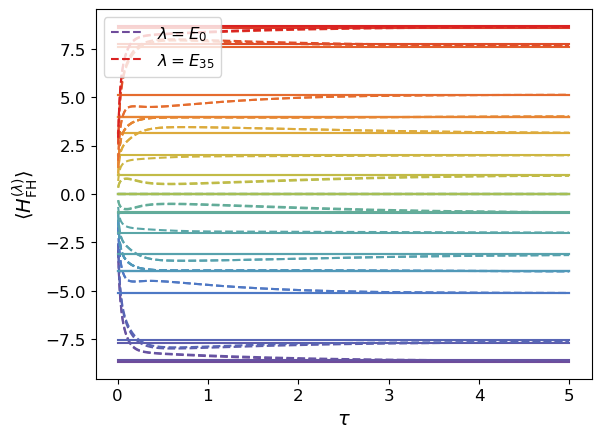

In [12]:
# Plot energy convergence
colors = tol_cmap('rainbow_PuRd').resampled(exact_E.size)
for i, λ in enumerate(exact_E):
    if i == 0 or i == exact_E.size-1:
        plt.plot(τs[2::2], stf.density_partition_calc(ρ_data['z'], ρ_data['O'], num_steps,
                                             λ, dτ)[1][1:] - λ, '--', color=colors(i),
                label='$\\lambda=E_{'+str(i)+'}$')
        plt.plot(τs[2::2], λ * np.ones(τs[2::2].size), color=colors(i))
    else:
        plt.plot(τs[2::2], λ * np.ones(τs[2::2].size), color=colors(i))
        plt.plot(τs[2::2], stf.density_partition_calc(ρ_data['z'], ρ_data['O'], num_steps,
                                             λ, dτ)[1][1:] - λ, '--', color=colors(i))
plt.xlabel("$\\tau$")
plt.ylabel("$\\langle H^{(\\lambda)}_{\\mathrm{FH}} \\rangle$")
plt.legend()
plt.savefig("2DFH_4site_conv_density.png", format='png', dpi=300)

In [13]:
# Calculate final energy values as λ is varied
λs = np.linspace(-1.1 * abs(exact_E[0]), 1.1 * abs(exact_E[0]), 100)
calculated_energies = [stf.density_partition_calc(ρ_data['z'], ρ_data['O'],
                                                  num_steps, _, dτ)[1][-1]
                      for _ in λs]

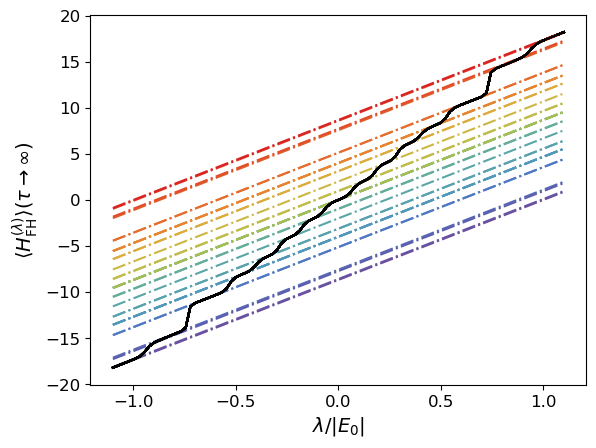

In [14]:
# Plot final energy values vs λ
for i, e in enumerate(exact_E):
    plt.plot(λs / abs(exact_E[0]), e * np.ones(λs.shape[0]) + λs,
            '-.', color=colors(i))
    plt.plot(λs / abs(exact_E[0]), calculated_energies, 'k')
    
plt.ylabel("$\\langle H^{(\\lambda)}_{\\mathrm{FH}} \\rangle(\\tau \\rightarrow \\infty)$")
plt.xlabel("$\\lambda/|E_0|$")
plt.savefig("2DFH_4site_sweep_density.png", format='png', dpi=300)